In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = 'arial'
plt.rcParams['text.usetex'] = True

N = 100
DATASETS = ['f', 'e', 's', 'w']
MODELS = ['L', 'M', 'F']
MAX_N_MISSING = 3
MAX_CHANGE_NUM = 4
CONFIDENCE = 0.75
CONFIDENCES = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
N_SAMPLING = 100
N_SAMPLINGS = [100, 200, 300, 400, 500]

N_MISSINGS = [1, 2, 3]
METHODS = ['mean', 'knn', 'mice', 'robust', 'armin']
MARKERS = {
    'mean': '^', 
    'knn': 'v', 
    'mice': 'd',
    'robust': 's',
    'armin': 'o' 
}
METHODS_FULL = {
    'mean': 'ImputationAR (mean)', 
    'knn': 'ImputationAR (k-NN)', 
    'mice': 'ImputationAR (MICE)',
    'robust': 'RobustAR',
    'armin': 'ARMIN (ours)' 
}
DATASETS_FULL = {
    'f': 'FICO',
    'e': 'EmployeeAttrition',
    's': 'StudentPerformance',
    'w': 'WineQuality',
}
MODELS_FULL = {
    'L': 'LR',
    'M': 'MLP',
    'F': 'RF',
}

In [2]:
from scipy import stats

def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)
    std_error = std_dev / np.sqrt(n)
    if n > 30:
        critical_value = stats.norm.ppf((1 + confidence) / 2)
    else:
        critical_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin_of_error = critical_value * std_error
    return margin_of_error

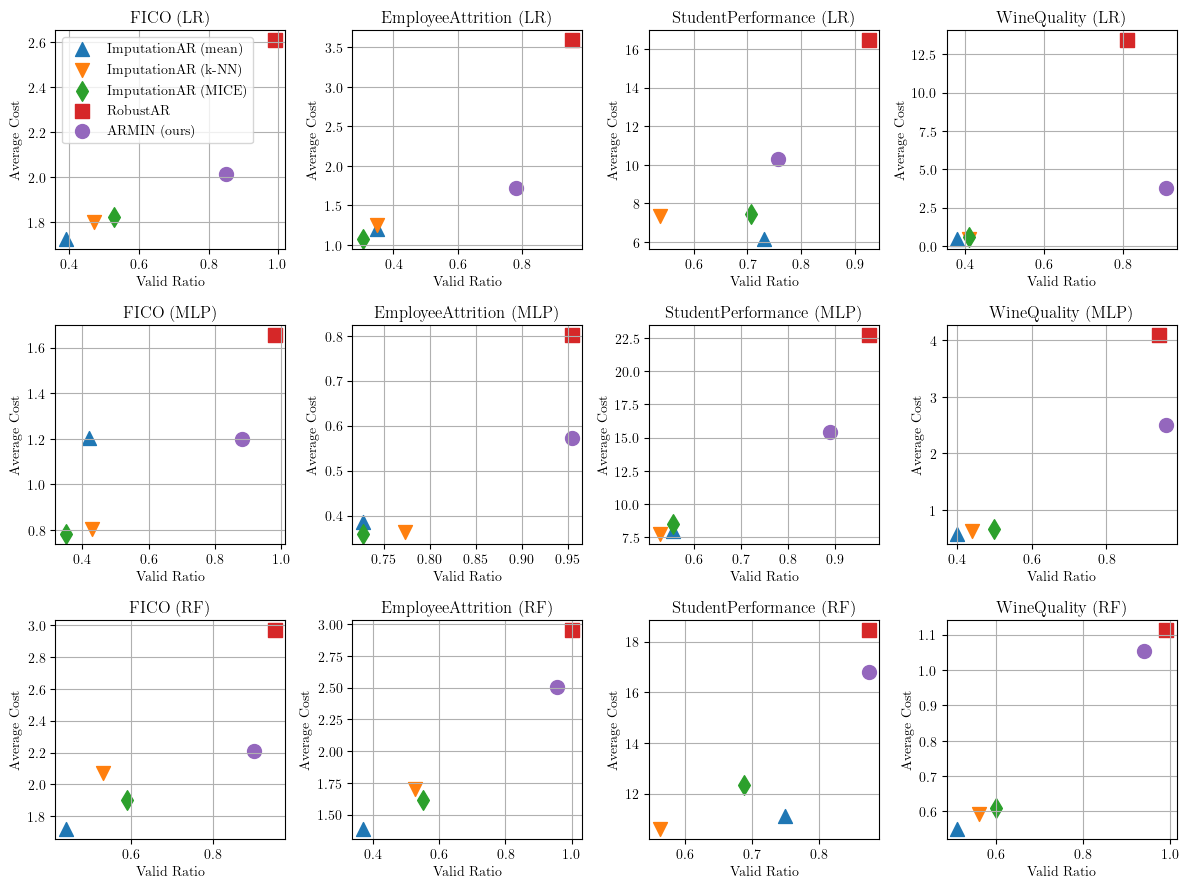

In [3]:
n_missing = 2

fig = plt.figure(figsize=(12, 9))
for i, model in enumerate(MODELS):
    for j, dataset in enumerate(DATASETS):
        df = pd.read_csv('./res/{}/{}_TLPS.csv'.format(model, dataset))
        # for n_missing in N_MISSINGS:
        plt.subplot(len(MODELS), len(DATASETS), i * len(DATASETS) + j + 1)
        df_k = df[df['n_missing'] == n_missing]
        for method in METHODS:
            df_method = df_k[df_k['method'] == method]
            plt.scatter([df_method['valid'].mean()], [df_method['cost'].mean()], label=METHODS_FULL[method], marker=MARKERS[method], s=100)
        plt.xlabel('Valid Ratio')
        plt.ylabel('Average Cost')
        plt.title('{} ({})'.format(DATASETS_FULL[dataset], MODELS_FULL[model]))
        plt.grid()
        if i==0 and j==0: plt.legend()
plt.tight_layout()

plt.savefig('./fig/compare.png', bbox_inches='tight', pad_inches=0.01)
plt.savefig('./fig/compare.pdf', bbox_inches='tight', pad_inches=0.01)

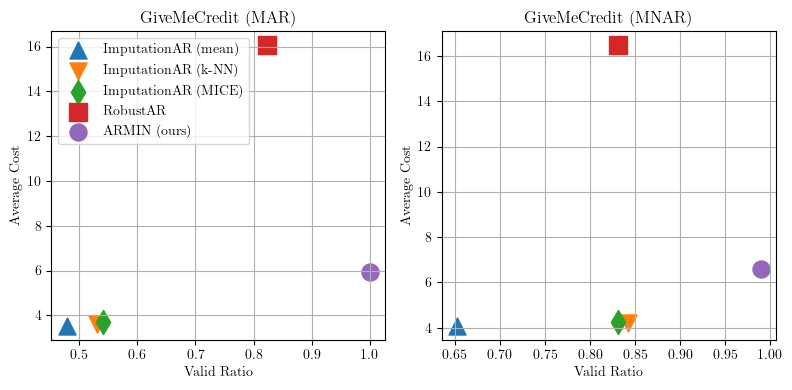

In [4]:
fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
df = pd.read_csv('./res/L/g_MAR_TLPS.csv')
for method in METHODS:
    if method == 'armin':
        df_method = df[(df['method'] == method) & (df['confidence'] == CONFIDENCE)]
    else:
        df_method = df[df['method'] == method]
    plt.scatter([df_method['valid'].mean()], [df_method['cost'].mean()], label=METHODS_FULL[method], marker=MARKERS[method], s=150)
plt.xlabel('Valid Ratio')
plt.ylabel('Average Cost')
plt.title('GiveMeCredit (MAR)')
plt.grid()
plt.legend()
# plt.tight_layout()

plt.subplot(1, 2, 2)
df = pd.read_csv('./res/L/g_MNAR_TLPS.csv')
for method in METHODS:
    if method == 'armin':
        df_method = df[(df['method'] == method) & (df['confidence'] == CONFIDENCE)]
    else:
        df_method = df[df['method'] == method]
    plt.scatter([df_method['valid'].mean()], [df_method['cost'].mean()], label=METHODS_FULL[method], marker=MARKERS[method], s=150)
plt.xlabel('Valid Ratio')
plt.ylabel('Average Cost')
plt.title('GiveMeCredit (MNAR)')
plt.grid()
# plt.legend()
plt.tight_layout()

plt.savefig('./fig/compare_mar_mnar.png', bbox_inches='tight', pad_inches=0.01)
plt.savefig('./fig/compare_mar_mnar.pdf', bbox_inches='tight', pad_inches=0.01)

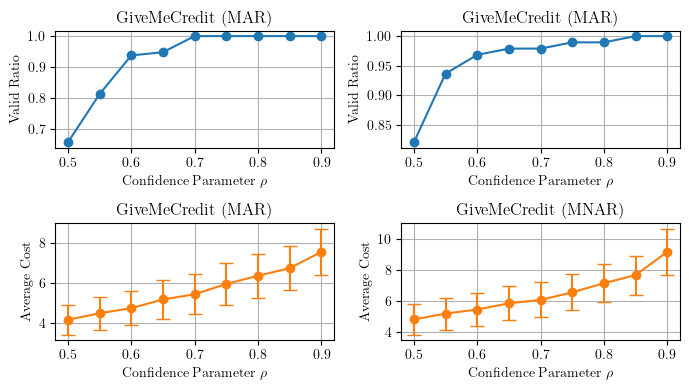

In [5]:
fig = plt.figure(figsize=(7, 4))

df = pd.read_csv('./res/L/g_MAR_TLPS.csv'.format(dataset))
df = df[df.method == 'armin']

plt.subplot(2, 2, 1)
valid_mean = df.groupby('confidence')['valid'].mean().values
plt.plot(CONFIDENCES, valid_mean, marker='o', c='tab:blue')
plt.xlabel(r'Confidence Parameter $\rho$')
plt.ylabel('Valid Ratio')
plt.title('GiveMeCredit (MAR)')
plt.grid()

plt.subplot(2, 2, 3)
cost_mean = df.groupby('confidence')['cost'].mean().values
cost_ci = [confidence_interval(df[df.confidence == confidence]['cost'].values) for confidence in CONFIDENCES]
plt.errorbar(CONFIDENCES, cost_mean, cost_ci, marker='o', capsize=5, c='tab:orange')
plt.xlabel(r'Confidence Parameter $\rho$')
plt.ylabel('Average Cost')
plt.title('GiveMeCredit (MAR)')
plt.grid()


df = pd.read_csv('./res/L/g_MNAR_TLPS.csv'.format(dataset))
df = df[df.method == 'armin']

plt.subplot(2, 2, 2)
valid_mean = df.groupby('confidence')['valid'].mean().values
plt.plot(CONFIDENCES, valid_mean, marker='o', c='tab:blue')
plt.xlabel(r'Confidence Parameter $\rho$')
plt.ylabel('Valid Ratio')
plt.title('GiveMeCredit (MAR)')
plt.grid()

plt.subplot(2, 2, 4)
cost_mean = df.groupby('confidence')['cost'].mean().values
cost_ci = [confidence_interval(df[df.confidence == confidence]['cost'].values) for confidence in CONFIDENCES]
plt.errorbar(CONFIDENCES, cost_mean, cost_ci, marker='o', capsize=5, c='tab:orange')
plt.xlabel(r'Confidence Parameter $\rho$')
plt.ylabel('Average Cost')
plt.title('GiveMeCredit (MNAR)')
plt.grid()

plt.tight_layout()

plt.savefig('./fig/sens_confidence.png', bbox_inches='tight', pad_inches=0.01)
plt.savefig('./fig/sens_confidence.pdf', bbox_inches='tight', pad_inches=0.01)

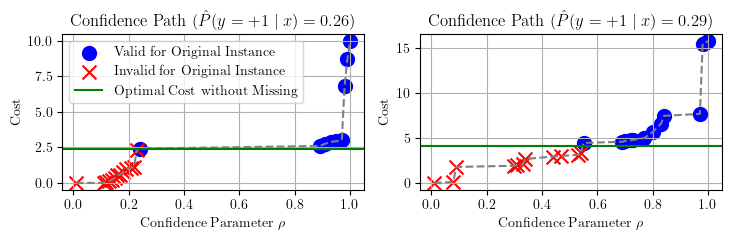

In [6]:
df = pd.read_csv('./res/L/path_g_MAR_TLPS.csv')
Ns = df.n.unique()
Ns = Ns[np.linspace(0, len(Ns)-1, 15, dtype=int)][[7, 8]]

fig = plt.figure(figsize=(11, 2.5))
for i, n in enumerate(Ns):
    df_n = df[df.n == n]
    df_optim = df_n[df_n.method == 'optimal']
    df_armin = df_n[df_n.method == 'armin']

    rhos = df_armin.confidence.values
    costs = df_armin.cost.values
    valids = df_armin.valid.values

    plt.subplot(1, 3, i+1)
    plt.plot(rhos, costs, c='gray', linestyle='dashed')
    plt.scatter(rhos[valids], costs[valids], c='blue', label='Valid for Original Instance', s=100, marker='o')
    plt.scatter(rhos[~valids], costs[~valids], c='red', label='Invalid for Original Instance', s=100, marker='x')
    plt.axhline(df_optim.cost.values[0], color='green', label='Optimal Cost without Missing')
    plt.title(r'Confidence Path ($\hat P(y=+1 \mid x) = {:.2}$)'.format(df_armin.y_prob_init.values[0]))
    plt.xlabel(r'Confidence Parameter $\rho$')
    plt.ylabel('Cost')
    if i==0: plt.legend()
    plt.grid()
    plt.tight_layout()    
    
plt.savefig('./fig/path_mar.png', bbox_inches='tight', pad_inches=0.01)
plt.savefig('./fig/path_mar.pdf', bbox_inches='tight', pad_inches=0.01)

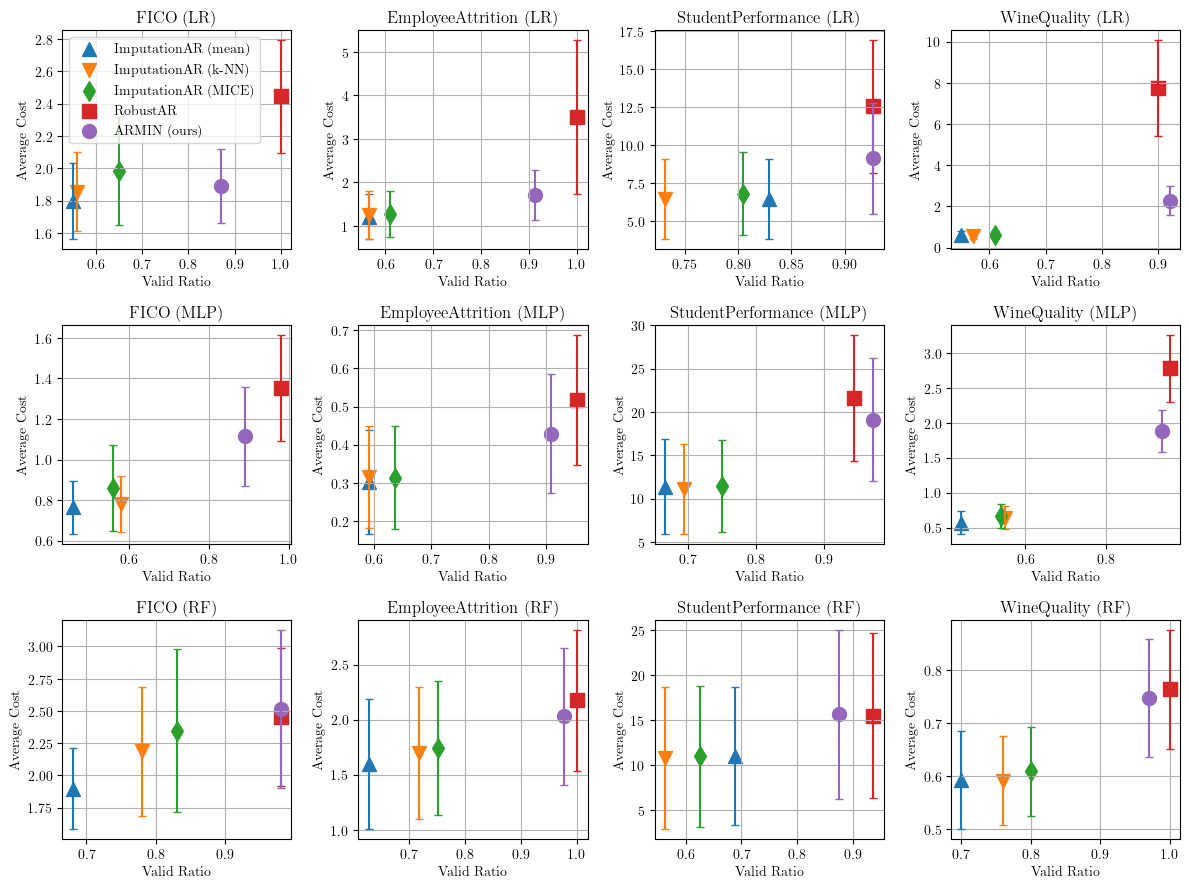

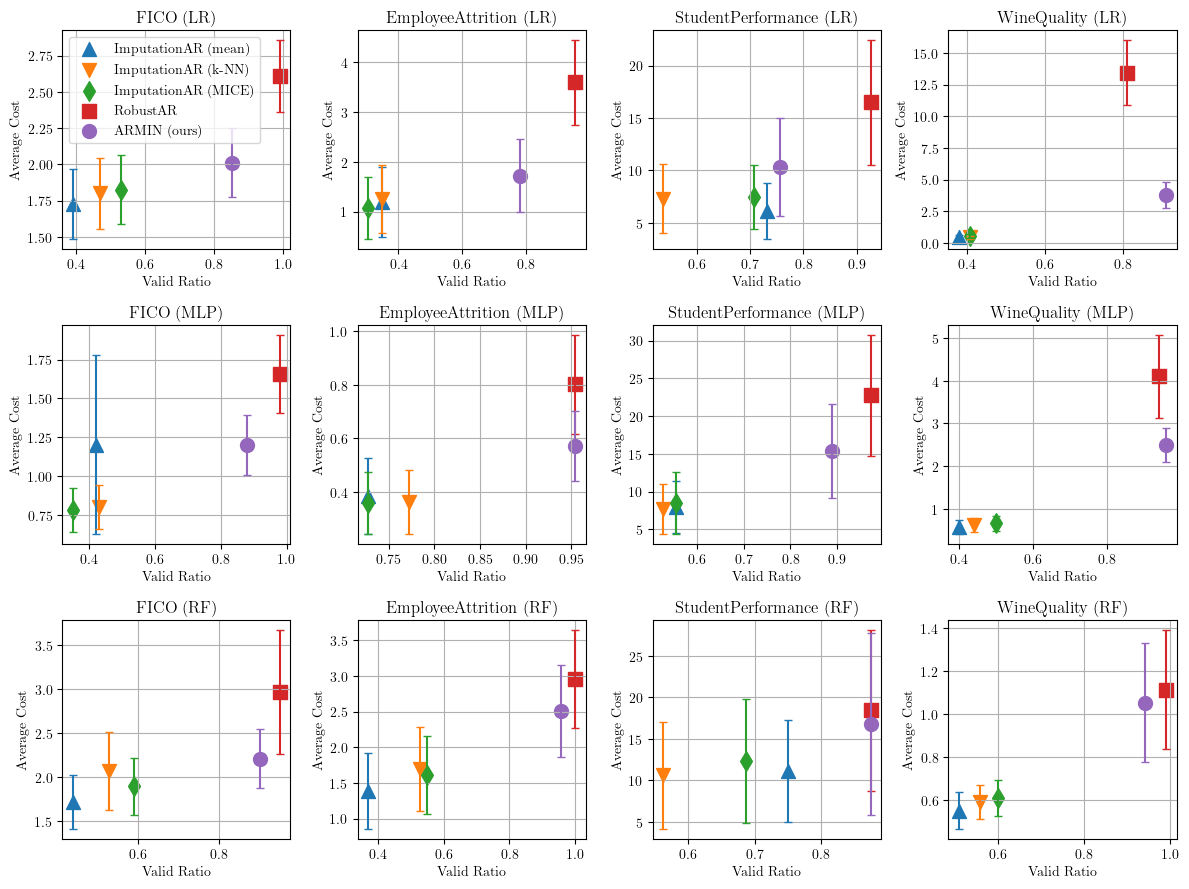

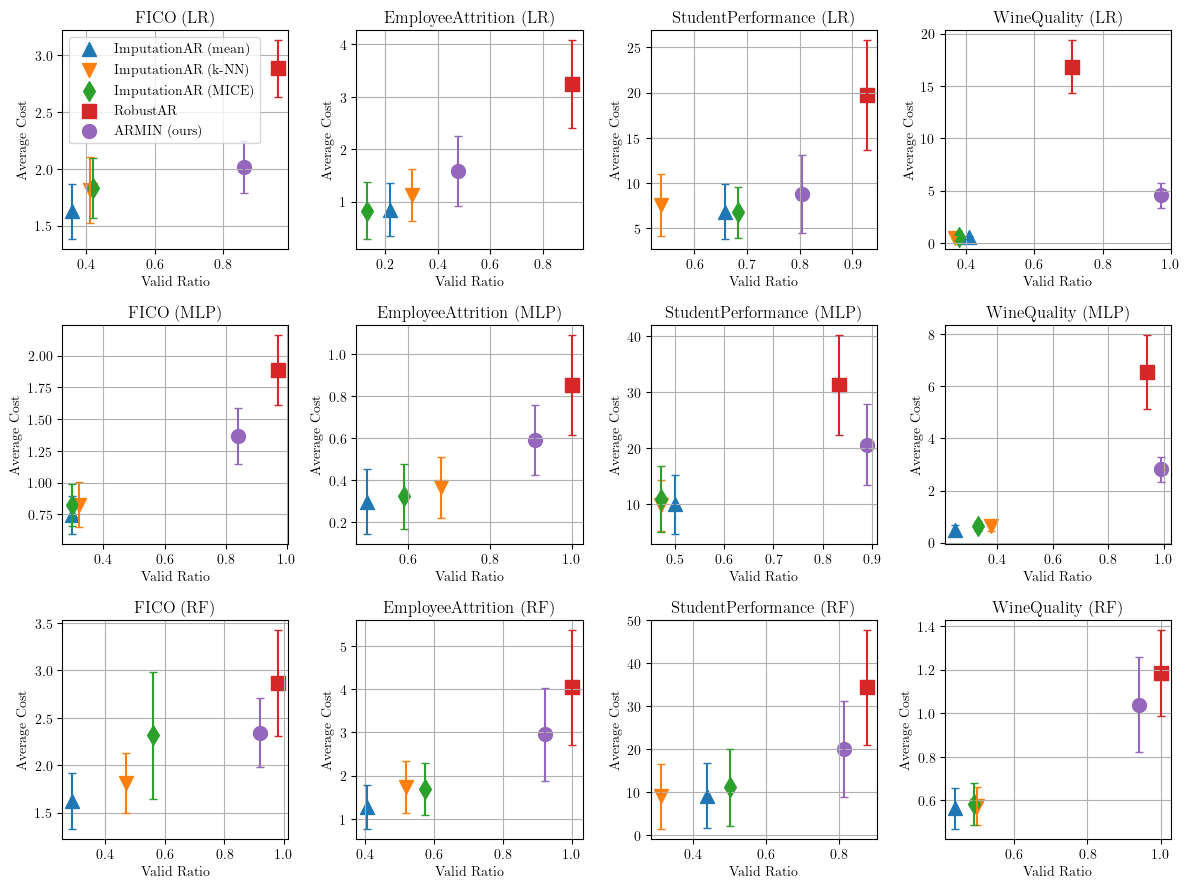

In [7]:
for n_missing in N_MISSINGS:

    fig = plt.figure(figsize=(12, 9))
    for i, model in enumerate(MODELS):
        for j, dataset in enumerate(DATASETS):
            df = pd.read_csv('./res/{}/{}_TLPS.csv'.format(model, dataset))
            # for n_missing in N_MISSINGS:
            plt.subplot(len(MODELS), len(DATASETS), i * len(DATASETS) + j + 1)
            df_k = df[df['n_missing'] == n_missing]
            for method in METHODS:
                df_method = df_k[df_k['method'] == method]
                plt.scatter([df_method['valid'].mean()], [df_method['cost'].mean()], label=METHODS_FULL[method], marker=MARKERS[method], s=100)
                plt.errorbar([df_method['valid'].mean()], [df_method['cost'].mean()], yerr=[confidence_interval(df_method['cost'].values)], capsize=3)
            plt.xlabel('Valid Ratio')
            plt.ylabel('Average Cost')
            plt.title('{} ({})'.format(DATASETS_FULL[dataset], MODELS_FULL[model]))
            plt.grid()
            if i==0 and j==0: plt.legend()
    plt.tight_layout()

    plt.savefig('./fig/appendix/compare_{}.png'.format(n_missing), bbox_inches='tight', pad_inches=0.01)
    plt.savefig('./fig/appendix/compare_{}.pdf'.format(n_missing), bbox_inches='tight', pad_inches=0.01)

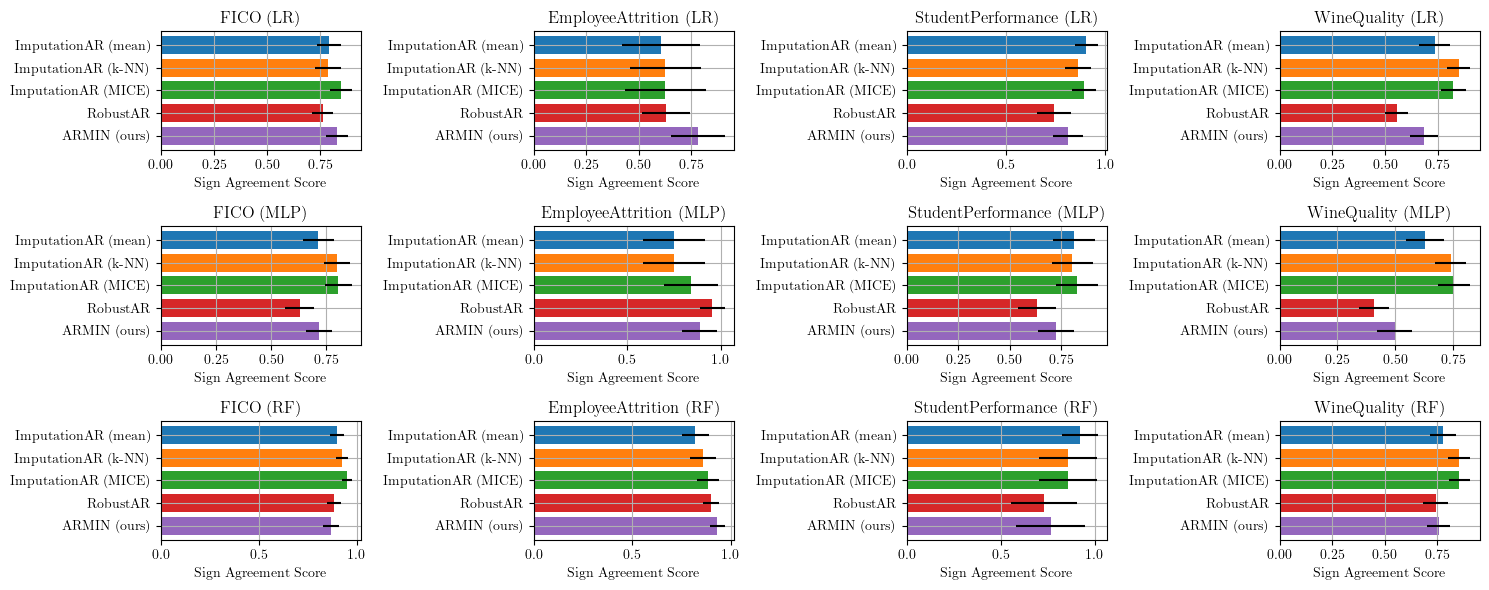

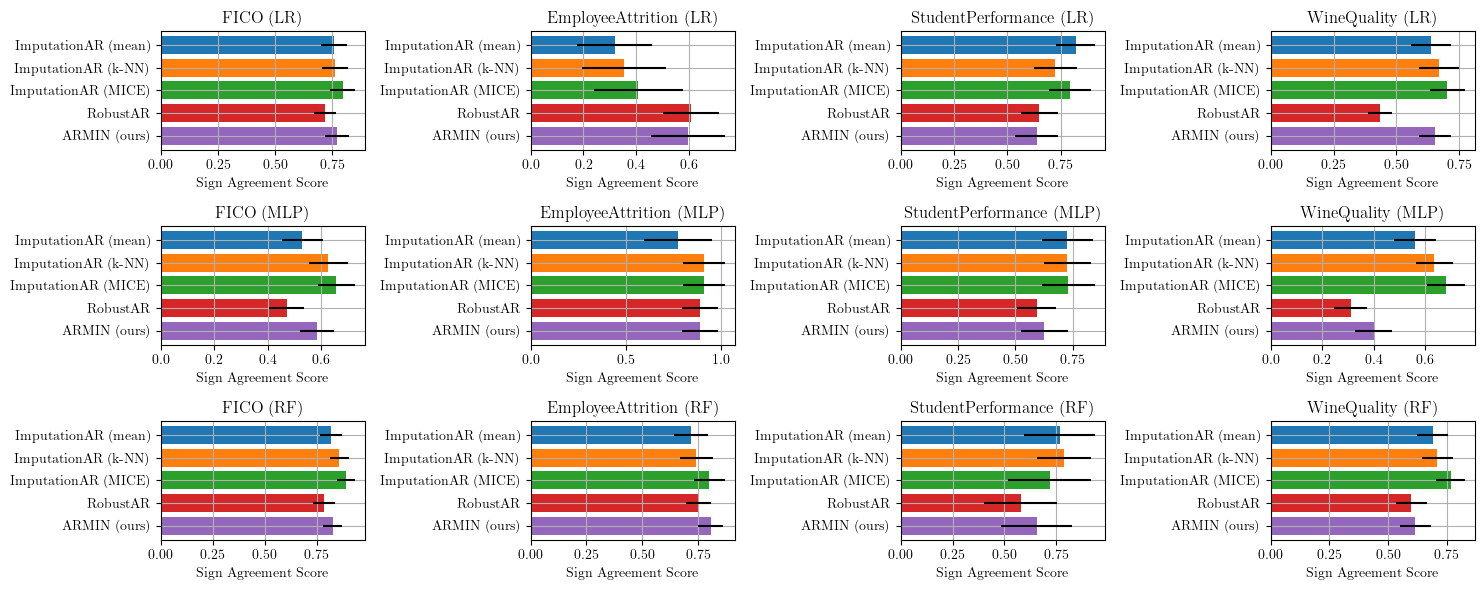

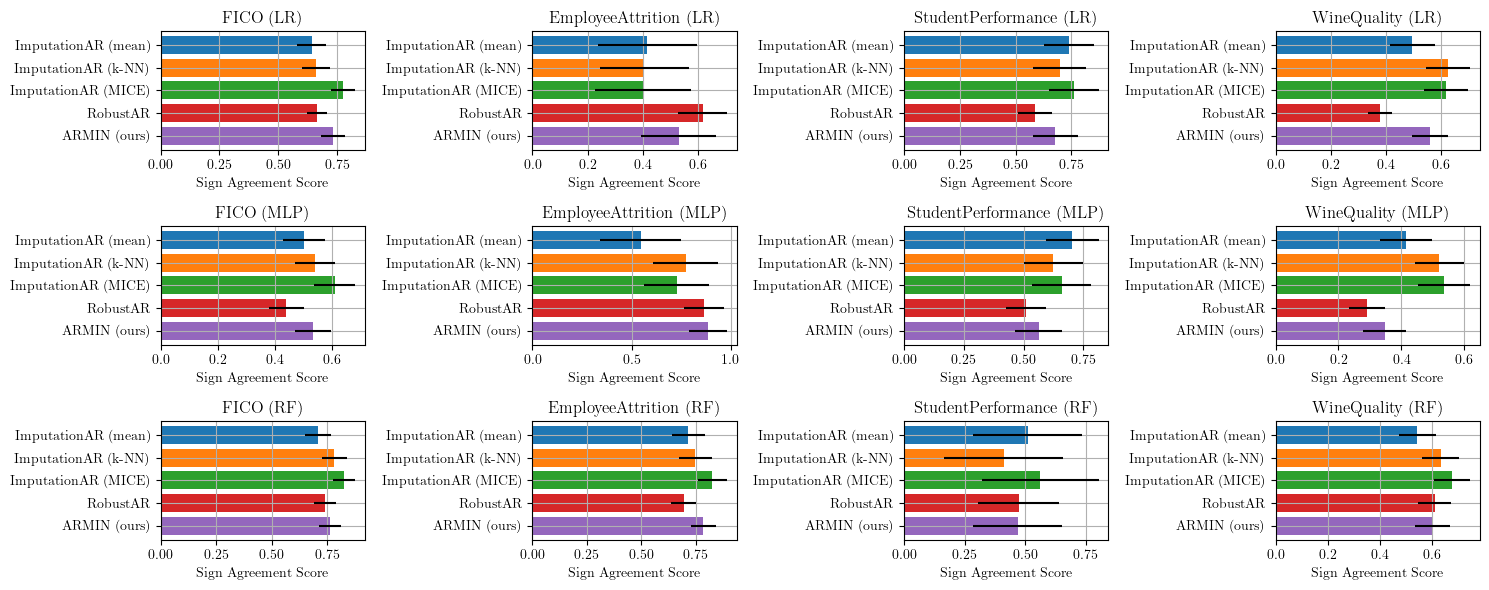

In [8]:
for n_missing in N_MISSINGS:

    fig = plt.figure(figsize=(15, 6))
    for i, model in enumerate(MODELS):
        for j, dataset in enumerate(DATASETS):
            df = pd.read_csv('./res/{}/{}_TLPS.csv'.format(model, dataset))
            plt.subplot(len(MODELS), len(DATASETS), i * len(DATASETS) + j + 1)
            df_k = df[df['n_missing'] == n_missing]
            plt.barh([METHODS_FULL[method] for method in METHODS], 
                     [df_k[df_k.method == method]['sign_agreement'].mean() for method in METHODS],
                     xerr=[confidence_interval(df_k[df_k.method == method]['sign_agreement'].values) for method in METHODS],
                     color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
            plt.xlabel('Sign Agreement Score')
            plt.gca().invert_yaxis()
            plt.title('{} ({})'.format(DATASETS_FULL[dataset], MODELS_FULL[model]))
            plt.grid()
    plt.tight_layout()

    plt.savefig('./fig/appendix/sas_{}.png'.format(n_missing), bbox_inches='tight', pad_inches=0.01)
    plt.savefig('./fig/appendix/sas_{}.pdf'.format(n_missing), bbox_inches='tight', pad_inches=0.01)

In [9]:
for n_missing in N_MISSINGS:

    print(r'Dataset & Method & LR & MLP & RF \\')
    for dataset in DATASETS: 
        print(r'\midrule')
        print(r'\multirow{5}{*}{\textbf{', DATASETS_FULL[dataset], '}}')
        df = df[df.n_missing == n_missing]
        for method in METHODS:
            s = '& {} '.format(METHODS_FULL[method])
            for model in MODELS:
                df = pd.read_csv('./res/{}/{}_TLPS.csv'.format(model, dataset))
                s += '& ${:.5} \pm {:.4}$ '.format(df[df['method']==method]['time'].mean(), df[df['method']==method]['time'].std())
            s += r'\\'
            print(s)
    print()

Dataset & Method & LR & MLP & RF \\
\midrule
\multirow{5}{*}{\textbf{ FICO }}
& ImputationAR (mean) & $0.023113 \pm 0.008066$ & $0.29502 \pm 0.2939$ & $0.43635 \pm 0.471$ \\
& ImputationAR (k-NN) & $0.023366 \pm 0.008898$ & $0.31684 \pm 0.3095$ & $0.44712 \pm 0.4693$ \\
& ImputationAR (MICE) & $0.0234 \pm 0.007134$ & $0.32673 \pm 0.3261$ & $0.47649 \pm 0.5398$ \\
& RobustAR & $0.13493 \pm 0.02382$ & $9.1928 \pm 37.16$ & $2.4749 \pm 6.716$ \\
& ARMIN (ours) & $0.10886 \pm 0.03743$ & $96.47 \pm 120.5$ & $230.14 \pm 196.0$ \\
\midrule
\multirow{5}{*}{\textbf{ EmployeeAttrition }}
& ImputationAR (mean) & $0.0046998 \pm 0.003787$ & $0.0091407 \pm 0.005912$ & $0.05703 \pm 0.0435$ \\
& ImputationAR (k-NN) & $0.024596 \pm 0.01656$ & $0.028607 \pm 0.01142$ & $0.062058 \pm 0.04942$ \\
& ImputationAR (MICE) & $0.0044343 \pm 0.003372$ & $0.010222 \pm 0.004549$ & $0.063377 \pm 0.05144$ \\
& RobustAR & $0.045233 \pm 0.007768$ & $0.077863 \pm 0.04334$ & $0.71814 \pm 0.6171$ \\
& ARMIN (ours) & $0.039

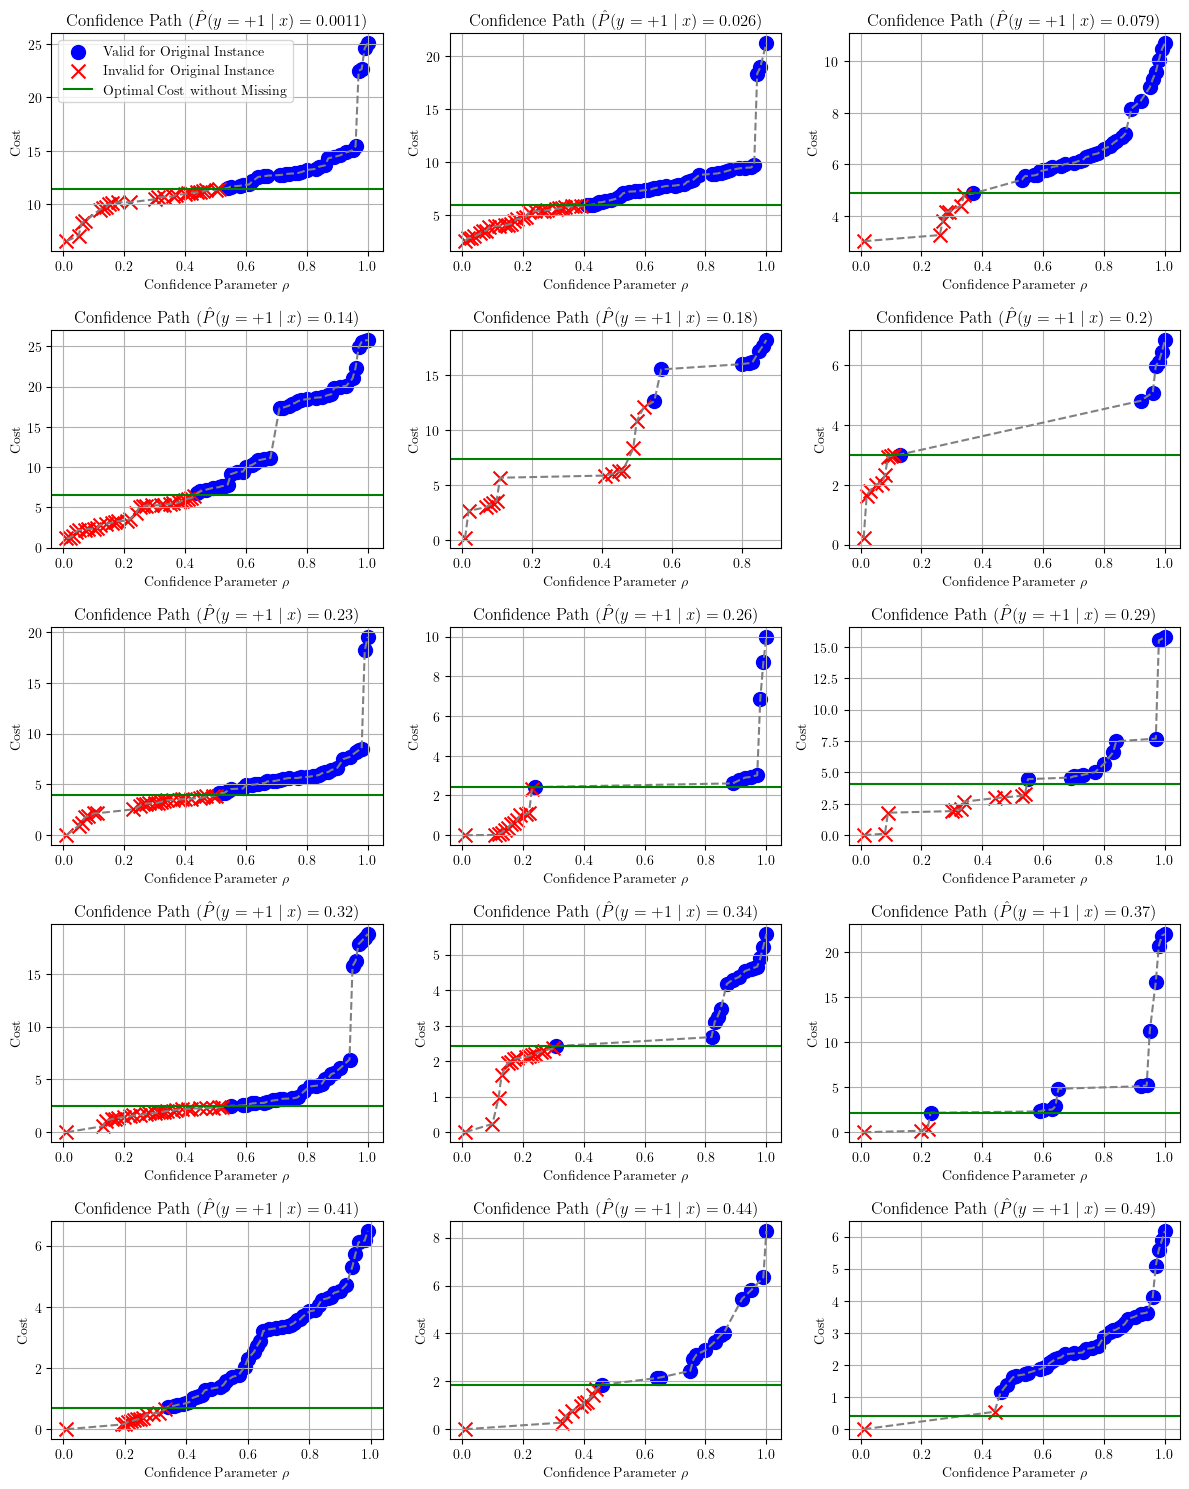

In [10]:
N_plot = 15
df = pd.read_csv('./res/L/path_g_MAR_TLPS.csv')
Ns = df.n.unique()
Ns = Ns[np.linspace(0, len(Ns)-1, N_plot, dtype=int)]

fig = plt.figure(figsize=(12, N_plot))
for i, n in enumerate(Ns):
    df_n = df[df.n == n]
    df_optim = df_n[df_n.method == 'optimal']
    df_armin = df_n[df_n.method == 'armin']

    rhos = df_armin.confidence.values
    costs = df_armin.cost.values
    valids = df_armin.valid.values

    plt.subplot(int(N_plot / 3), 3, i+1)
    plt.plot(rhos, costs, c='gray', linestyle='dashed')
    plt.scatter(rhos[valids], costs[valids], c='blue', label='Valid for Original Instance', s=100, marker='o')
    plt.scatter(rhos[~valids], costs[~valids], c='red', label='Invalid for Original Instance', s=100, marker='x')
    plt.axhline(df_optim.cost.values[0], color='green', label='Optimal Cost without Missing')
    plt.title(r'Confidence Path ($\hat P(y=+1 \mid x) = {:.2}$)'.format(df_armin.y_prob_init.values[0]))
    plt.xlabel(r'Confidence Parameter $\rho$')
    plt.ylabel('Cost')
    if i==0: plt.legend()
    plt.grid()
    plt.tight_layout()    
    
plt.savefig('./fig/appendix/path_mar.png', bbox_inches='tight', pad_inches=0.01)
plt.savefig('./fig/appendix/path_mar.pdf', bbox_inches='tight', pad_inches=0.01)

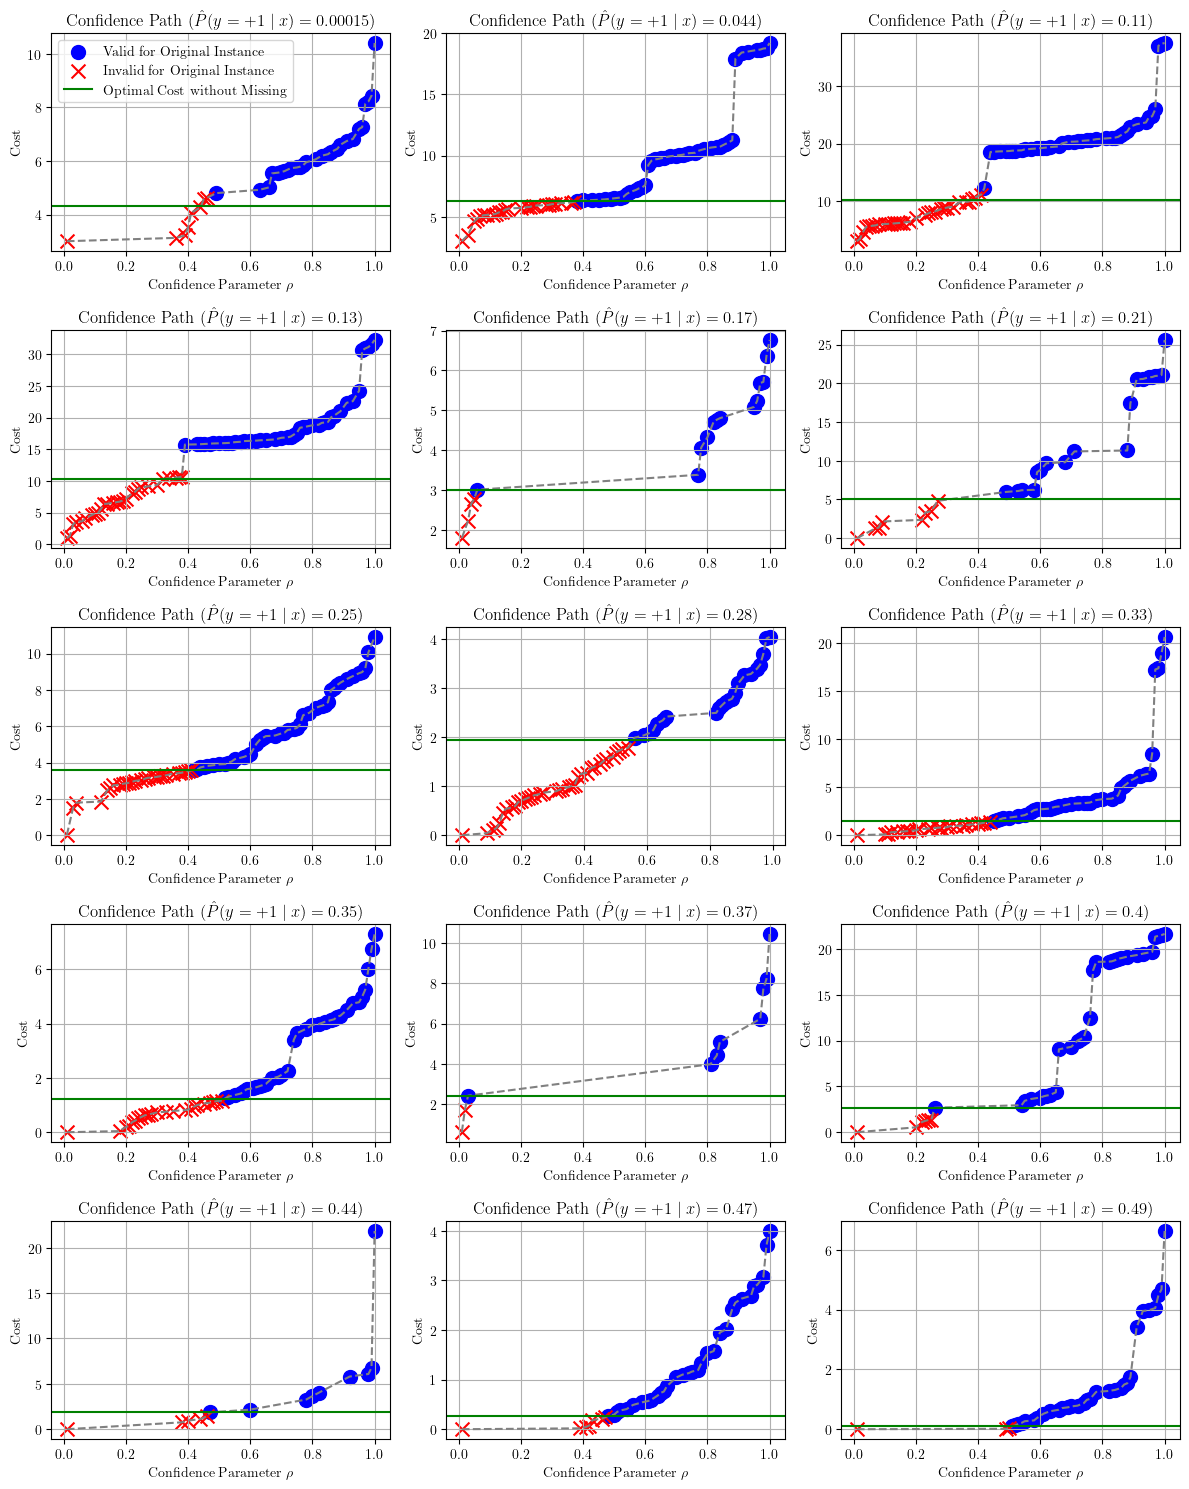

In [11]:
N_plot = 15
df = pd.read_csv('./res/L/path_g_MNAR_TLPS.csv')
Ns = df.n.unique()
Ns = Ns[np.linspace(0, len(Ns)-1, N_plot, dtype=int)]

fig = plt.figure(figsize=(12, N_plot))
for i, n in enumerate(Ns):
    df_n = df[df.n == n]
    df_optim = df_n[df_n.method == 'optimal']
    df_armin = df_n[df_n.method == 'armin']

    rhos = df_armin.confidence.values
    costs = df_armin.cost.values
    valids = df_armin.valid.values

    plt.subplot(int(N_plot / 3), 3, i+1)
    plt.plot(rhos, costs, c='gray', linestyle='dashed')
    plt.scatter(rhos[valids], costs[valids], c='blue', label='Valid for Original Instance', s=100, marker='o')
    plt.scatter(rhos[~valids], costs[~valids], c='red', label='Invalid for Original Instance', s=100, marker='x')
    plt.axhline(df_optim.cost.values[0], color='green', label='Optimal Cost without Missing')
    plt.title(r'Confidence Path ($\hat P(y=+1 \mid x) = {:.2}$)'.format(df_armin.y_prob_init.values[0]))
    plt.xlabel(r'Confidence Parameter $\rho$')
    plt.ylabel('Cost')
    if i==0: plt.legend()
    plt.grid()
    plt.tight_layout()    
    
plt.savefig('./fig/appendix/path_mnar.png', bbox_inches='tight', pad_inches=0.01)
plt.savefig('./fig/appendix/path_mnar.pdf', bbox_inches='tight', pad_inches=0.01)

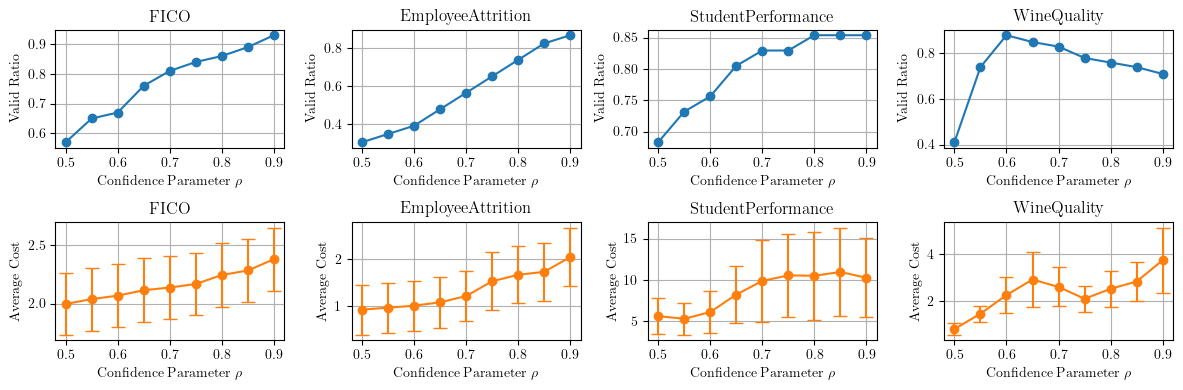

In [12]:
fig = plt.figure(figsize=(12, 4))
for i, dataset in enumerate(DATASETS):
    df = pd.read_csv('./res/L/sens_confidence_{}_TLPS.csv'.format(dataset))
    df = df[df.method == 'armin']

    plt.subplot(2, len(DATASETS), i + 1)
    valid_mean = df.groupby('confidence')['valid'].mean().values
    plt.plot(CONFIDENCES, valid_mean, marker='o', c='tab:blue')
    plt.xlabel(r'Confidence Parameter $\rho$')
    plt.ylabel('Valid Ratio')
    plt.title('{}'.format(DATASETS_FULL[dataset]))
    plt.grid()

    plt.subplot(2, len(DATASETS), len(DATASETS) + i + 1)
    cost_mean = df.groupby('confidence')['cost'].mean().values
    cost_ci = [confidence_interval(df[df.confidence == confidence]['cost'].values) for confidence in CONFIDENCES]
    plt.errorbar(CONFIDENCES, cost_mean, cost_ci, marker='o', capsize=5, c='tab:orange')
    plt.xlabel(r'Confidence Parameter $\rho$')
    plt.ylabel('Average Cost')
    plt.title('{}'.format(DATASETS_FULL[dataset]))
    plt.grid()

plt.tight_layout()

plt.savefig('./fig/appendix/sens_confidence.png', bbox_inches='tight', pad_inches=0.01)
plt.savefig('./fig/appendix/sens_confidence.pdf', bbox_inches='tight', pad_inches=0.01)

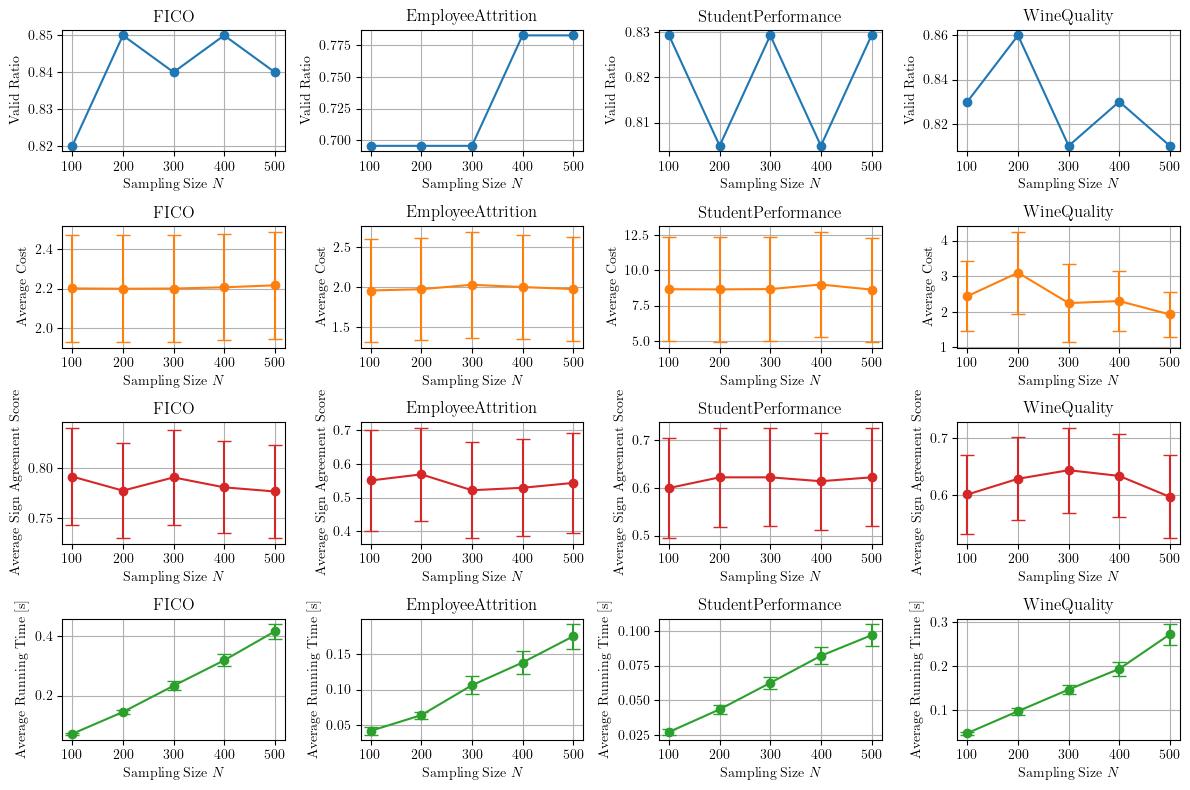

In [21]:
fig = plt.figure(figsize=(12, 8))
for i, dataset in enumerate(DATASETS):
    df = pd.read_csv('./res/L/sens_sampling_{}_TLPS.csv'.format(dataset))
    df = df[df.method == 'armin']

    plt.subplot(4, len(DATASETS), i + 1)
    valid_mean = df.groupby('n_sampling')['valid'].mean().values
    plt.plot(N_SAMPLINGS, valid_mean, marker='o', c='tab:blue')
    plt.xlabel(r'Sampling Size $N$')
    plt.ylabel('Valid Ratio')
    plt.title('{}'.format(DATASETS_FULL[dataset]))
    plt.grid()

    plt.subplot(4, len(DATASETS), len(DATASETS) + i + 1)
    cost_mean = df.groupby('n_sampling')['cost'].mean().values
    cost_ci = [confidence_interval(df[df.n_sampling == n_sampling]['cost'].values) for n_sampling in N_SAMPLINGS]
    plt.errorbar(N_SAMPLINGS, cost_mean, cost_ci, marker='o', capsize=5, c='tab:orange')
    plt.xlabel(r'Sampling Size $N$')
    plt.ylabel('Average Cost')
    plt.title('{}'.format(DATASETS_FULL[dataset]))
    plt.grid()

    plt.subplot(4, len(DATASETS), 2 * len(DATASETS) + i + 1)
    sas_mean = df.groupby('n_sampling')['sign_agreement'].mean().values
    sas_ci = [confidence_interval(df[df.n_sampling == n_sampling]['sign_agreement'].values) for n_sampling in N_SAMPLINGS]
    plt.errorbar(N_SAMPLINGS, sas_mean, sas_ci, marker='o', capsize=5, c='tab:red')
    plt.xlabel(r'Sampling Size $N$')
    plt.ylabel('Average Sign Agreement Score')
    plt.title('{}'.format(DATASETS_FULL[dataset]))
    plt.grid()

    plt.subplot(4, len(DATASETS), 3 * len(DATASETS) + i + 1)
    time_mean = df.groupby('n_sampling')['time'].mean().values
    time_ci = [confidence_interval(df[df.n_sampling == n_sampling]['time'].values) for n_sampling in N_SAMPLINGS]
    plt.errorbar(N_SAMPLINGS, time_mean, time_ci, marker='o', capsize=5, c='tab:green')
    plt.xlabel(r'Sampling Size $N$')
    plt.ylabel('Average Running Time [s]')
    plt.title('{}'.format(DATASETS_FULL[dataset]))
    plt.grid()

plt.tight_layout()

plt.savefig('./fig/appendix/sens_sampling.png', bbox_inches='tight', pad_inches=0.01)
plt.savefig('./fig/appendix/sens_sampling.pdf', bbox_inches='tight', pad_inches=0.01)

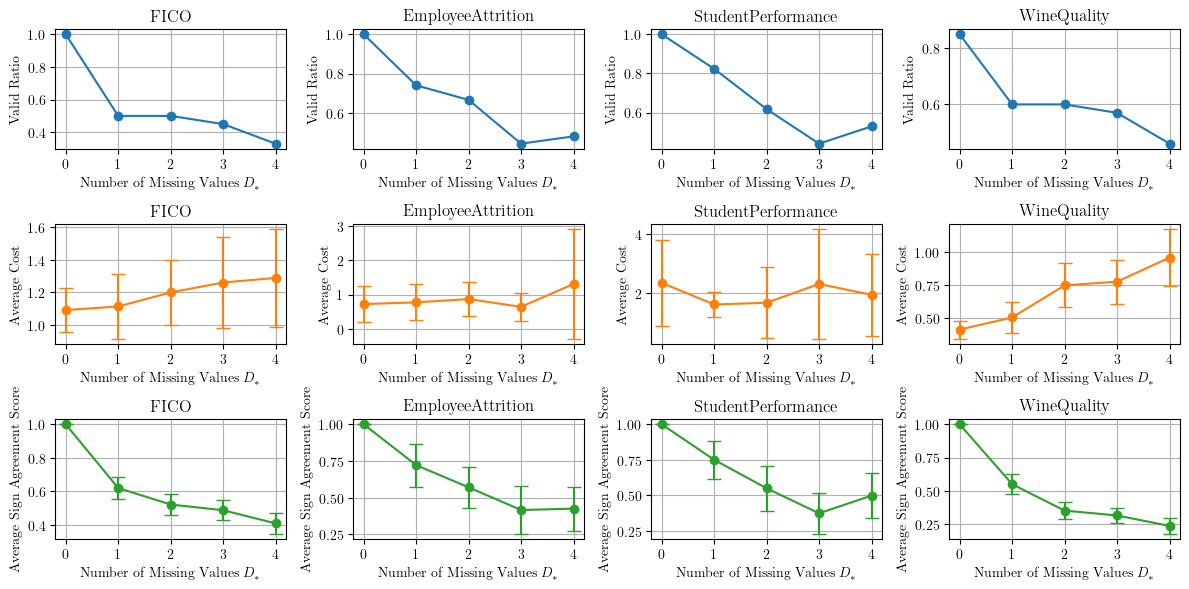

In [20]:
fig = plt.figure(figsize=(12, 6))
N_MISSINGS = [0, 1, 2, 3, 4]

for i, dataset in enumerate(DATASETS):
    df = pd.read_csv('./res/X/gbdt_{}_TLPS.csv'.format(dataset))

    plt.subplot(3, len(DATASETS), i + 1)
    valid_mean = df.groupby('n_missing')['valid'].mean().values
    plt.plot(N_MISSINGS, valid_mean, marker='o', c='tab:blue')
    plt.xlabel(r'Number of Missing Values $D_{\ast}$')
    plt.ylabel('Valid Ratio')
    plt.title('{}'.format(DATASETS_FULL[dataset]))
    plt.grid()

    plt.subplot(3, len(DATASETS), len(DATASETS) + i + 1)
    cost_mean = df.groupby('n_missing')['cost'].mean().values
    cost_ci = [confidence_interval(df[df.n_missing == n_missing]['cost'].values) for n_missing in N_MISSINGS]
    plt.errorbar(N_MISSINGS, cost_mean, cost_ci, marker='o', capsize=5, c='tab:orange')
    plt.xlabel(r'Number of Missing Values $D_{\ast}$')
    plt.ylabel('Average Cost')
    plt.title('{}'.format(DATASETS_FULL[dataset]))
    plt.grid()

    plt.subplot(3, len(DATASETS), 2 * len(DATASETS) + i + 1)
    sas_mean = df.groupby('n_missing')['sign_agreement'].mean().values
    sas_ci = [confidence_interval(df[df.n_missing == n_missing]['sign_agreement'].values) for n_missing in N_MISSINGS]
    plt.errorbar(N_MISSINGS, sas_mean, sas_ci, marker='o', capsize=5, c='tab:green')
    plt.xlabel(r'Number of Missing Values $D_{\ast}$')
    plt.ylabel('Average Sign Agreement Score')
    plt.title('{}'.format(DATASETS_FULL[dataset]))
    plt.grid()

plt.tight_layout()

plt.savefig('./fig/appendix/gbdt.png', bbox_inches='tight', pad_inches=0.01)
plt.savefig('./fig/appendix/gbdt.pdf', bbox_inches='tight', pad_inches=0.01)